This is based on http://lenkiefer.com/2018/06/10/kalman-filter-for-a-dynamic-linear-model-in-r/

Suppose we have a state process of interest $z_t$ that follows an ARIMA(1,1,0) process with drift.

Additionally, we have two signals; one for $z_t$ and one for $z_{t-1}$ that are simulateneously observed (noisy observations of $z$). Further suppose that the signal $y_{2,t}$ for $z_{t-1}$ is more precise and the concurrent signal $y_{1,t}$ is noisier and subject to bias $\mu_{y,1}$. We want to add weights for the two signals to make the most accurate estimation of the variable of interest $z_t$.

The state-space representation of our problem is given by 

$$Z_t = GZ_{t-1} + v_t, \quad v_t \sim N(0,W_t)$$
$$Y_t = FZ_t + w_t, \quad w_t \sim N(0,V_t)$$

where $Z_t = [z_t, z_{t-1}, 1]^{\prime}$ and
$$
G = \left(\begin{array}{cc} 
1 + \rho & - \rho & \mu_z \\
1 & 0 & 0 \\
0 & 0 & 1
\end{array}\right)
$$ 

and 
$$ W_t = \left(\begin{array}{cc} 
\sigma_z^2 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0
\end{array}\right)
$$ 

and
$$ F = \left(\begin{array}{cc} 
1 & 0 & \mu_{y1} \\
0 & 1 & 0 \\
0 & 0 & 1
\end{array}\right)
$$ 

and 
$$ V_t = \left(\begin{array}{cc} 
\sigma_{u1}^2 & 0 & 0 \\
0 & \sigma_{u2}^2 & 0 \\
0 & 0 & 0
\end{array}\right)
$$ 

We begin by generating a sample path for our process

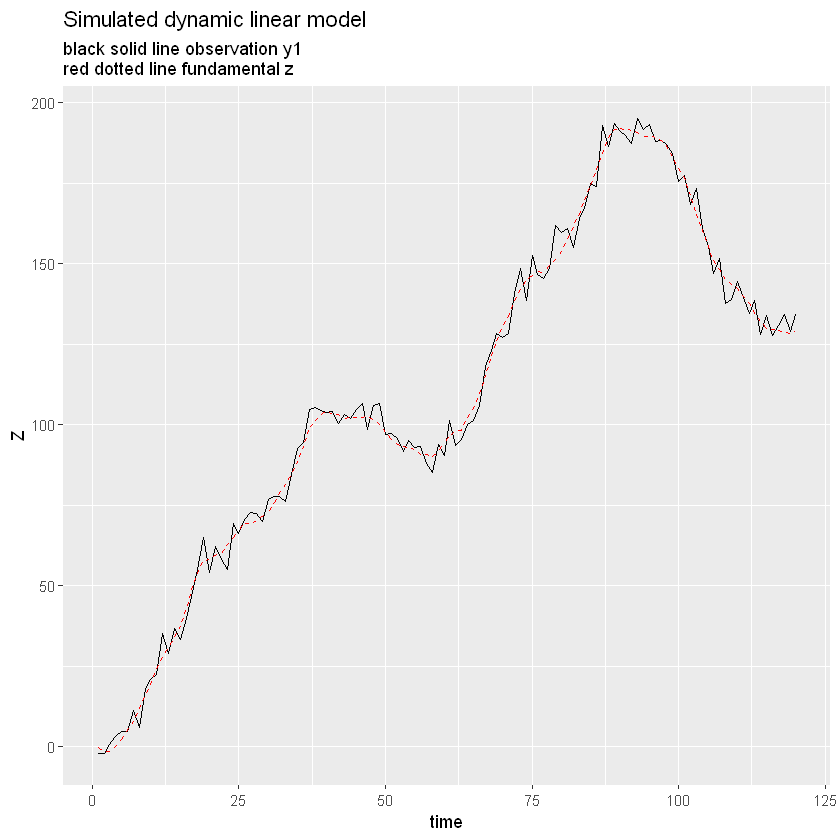

In [10]:
# Load Libraries
# install.packages('dlm')
library(dlm)
library(tidyverse) # for plotting

# set parameters
mu_z <- 0.1
mu_y <- 0.5 # spread between observation and data
rho1 <- 0.9 
sig_z <- 1
sig_u1 <- 10
sig_u2 <- 0.1

# The dlm object specifies a linaer model that fits the specified dynamics
GG <- matrix(c(1+rho1,-rho1,mu_z,1,0,0,0,0,1),nrow=3,byrow=TRUE)
FF <- matrix(c(1,0,mu_y,0,1,0,0,0,1),nrow=3,byrow=TRUE)
m0 <- matrix(c(0,0,0), nrow=3)
C0 <- matrix(rep(0,9),nrow=3)
W <- matrix(c(sig_z,0,0,
              0,0,0,
              0,0,0),nrow=3,byrow=TRUE)
V <- matrix(c(sig_u1,0,0,
              0,sig_u2,0,
              0,0,0),nrow=3,byrow=TRUE)
my_dlm <- dlm(FF=FF,V=V,GG=GG,W=W,V=V,m0=c(0,0,1),C0=C0)

# After setting it up we can simulate from the process using dlm::dlmForecast.
# https://rdrr.io/cran/dlm/man/dlmForecast.html
set.seed(20180610)  #set seed for reproducible results
y1 <- dlmForecast(my_dlm, nAhead=120,sampleNew=1)

# Arrange the dataframe for plotting
df <- data.frame(y=y1$newObs, z=y1$newStates)
df$id <- seq.int(nrow(df))

# Plot
ggplot(data=df, aes(x=id,y=y.1))+
  geom_line()+
  geom_line(linetype=2,aes(y=z.1),color="red")+
  labs(x="time",y="Z", title="Simulated dynamic linear model", subtitle="black solid line observation y1\nred dotted line fundamental z")


Next, we estimate a dynamic linear model using Maximum Likelihood.

In [11]:
y_dlmfc <- function(par=c(rho1,sig_z,sig_u1,sig_u2,mu_z,mu_y)){
  rho1 = par[1]
  sig_z = par[2]  
  sig_u1 = par[3] 
  sig_u2 = par[4]
  mu_z = par[5]
  mu_y = par[6]
  GG <- matrix(c(1+rho1,-rho1,mu_z,1,0,0,0,0,1),nrow=3,byrow=TRUE)
  FF <- matrix(c(1,0,mu_y,0,1,0,0,0,1),nrow=3,byrow=TRUE)
  m0 <- matrix(c(0,0,0), nrow=3)
  C0 <- matrix(rep(0,9),nrow=3)
  W <- matrix(c(sig_z,0,0,
                0,0,0,
                0,0,0),nrow=3,byrow=TRUE)
  V <- matrix(c(sig_u1,0,0,
                0,sig_u2,0,
                0,0,0),nrow=3,byrow=TRUE)
  my_dlm3 <- dlm(FF=FF,V=V,GG=GG,W=W,V=V,m0=c(0,0,1),C0=C0)
  return(my_dlm3)
}

my_mle <- dlmMLE(matrix(unlist(y1$newObs),ncol=2), 
                 rep(0.5,6),  #set initial values
                 my_dlmfc, lower=c(-1,0,0,0,-Inf,-Inf) # as dlmMLE uses optim L-BFGS-B method by default we can set lower/upper bounds to parameters to keep us out of trouble
                 )
                 
my_comp <- data.frame(row.names=c("rho1","sig_z","sig_u1","sig_u2","mu_z","mu_y"),real=c(rho1,sig_z,sig_u1,sig_u2,mu_z,mu_y), mle=my_mle$par) 
knitr::kable(my_comp,digits=3, caption = "Checking MLE against simulated data")



Table: Checking MLE against simulated data

|       | real|    mle|
|:------|----:|------:|
|rho1   |  0.9|  0.919|
|sig_z  |  1.0|  1.156|
|sig_u1 | 10.0| 13.994|
|sig_u2 |  0.1|  0.196|
|mu_z   |  0.1|  0.085|
|mu_y   |  0.5|  0.461|

The MLE estimates aren't too far off from the true process. Let's try to make it better by studying how the parameters might affect the value of the signals. If the estimates are noisy, then we put less weight on the parameter. In the context of the Kalman Filter the Kalman Gain serves as a useful summary statistic.

In [12]:
my_kgain <- function(i=1, # signal input ( 1 or 2 in our example)
                     j=1, # gain location (should be 1 or 2 in our exmample)
                     j2=1, # should be same as j
                     myk.in=myk,   # input results, the output of a dlmFilter call (see below)
                     my_dlm.in = my_dlm2 # input dlm object, result of dlm call (see below)
                     ){
  vmt <- myk.in$U.C[[i]] %*% diag(myk.in$D.C[i,] ^ 2) %*% t(myk.in$U.C[[i]])
  vat <- myk.in$U.R[[i]] %*% diag(myk.in$D.R[i,] ^ 2) %*% t(myk.in$U.R[[i]])
  K_gain <-vat* t(FF(my_dlm.in)) * solve(FF(my_dlm.in)* vat * t(FF(my_dlm.in)) + V(my_dlm.in))
  return(K_gain[[j,j2]])
}

# estimated gain:
myf <- function(par=c(rho1,sig_z,sig_u1,sig_u2,mu_z,mu_y)){
  rho1 = par[1]
  sig_z = par[2]  
  sig_u1 = par[3] 
  sig_u2 = par[4]
  mu_z = par[5]
  mu_y = par[6]
  GG <- matrix(c(1+rho1,-rho1,1,0),nrow=2,byrow=TRUE)
  FF <- matrix(c(1,0,0,1),nrow=2,byrow=TRUE)
  m0 <- matrix(c(0,0), nrow=2)
  C0 <- matrix(rep(0,4),nrow=2)
  W <- matrix(c(sig_z,0,0,0),nrow=2,byrow=TRUE)
  V <- matrix(c(sig_u1,0,0,sig_u2),nrow=2,byrow=TRUE)

  my_dlm3 <- dlm(FF=FF,V=V,GG=GG,W=W,V=V,m0=c(0,0),C0=C0)
  y1 <- dlmForecast(my_dlm3, nAhead=20,sampleNew=1)
  df <- data.frame(y=y1$newObs, z=y1$newStates)
  df$id <- seq.int(nrow(df))
  
  myk <- dlmFilter(as.matrix(df[,1:2]), my_dlm3)
  # i,j refer to the position on matrix
  dfk <- data.frame(id=1:nrow(myk$a)) %>% mutate(k11=map(id,my_kgain,1,1,myk,my_dlm3),
                                                 k12=map(id,my_kgain,1,2,myk,my_dlm3),
                                                 k21=map(id,my_kgain,2,1,myk,my_dlm3),
                                                 k22=map(id,my_kgain,2,2,myk,my_dlm3) )
  return(tail(dfk,1) %>% select(k11,k22))
}

knitr::kable(myf(my_comp$mle)  %>%  unlist %>% t %>% data.frame,
             digits=3, 
             row.names=F,
             col.names=c("Gain for y_1","Gain for y_2"),
             caption="Kalman Gain After 20 Periods")



Table: Kalman Gain After 20 Periods

| Gain for y_1| Gain for y_2|
|------------:|------------:|
|        0.308|        0.891|

Fix the innovation variance for the unobserved series such that $\sigma_z^2 = 1$ and set the intercepts $m u_z$ and $ m u_y$ to zero. This allows us to drop a state variable.

In [17]:
# estimated gain:
myf2 <- function(rho1 = 0.9 ,
                   sig_z = 1,
                   sig_u1 = 10,
                   sig_u2 = 0.001,
                   mu_z=0,
                   mu_y=0){

 GG <- matrix(c(1+rho1,-rho1,1,0),nrow=2,byrow=TRUE)
  FF <- matrix(c(1,0,0,1),nrow=2,byrow=TRUE)
  m0 <- matrix(c(0,0), nrow=2)
  C0 <- matrix(rep(0,4),nrow=2)
  W <- matrix(c(sig_z,0,0,0),nrow=2,byrow=TRUE)
  V <- matrix(c(sig_u1,0,0,sig_u2),nrow=2,byrow=TRUE)
  my_dlm3 <- dlm(FF=FF,V=V,GG=GG,W=W,V=V,m0=c(0,0),C0=C0)
  y1 <- dlmForecast(my_dlm3, nAhead=20,sampleNew=1)
  df <- data.frame(y=y1$newObs, z=y1$newStates)
  df$id <- seq.int(nrow(df))
  myk <- dlmFilter(as.matrix(df[,1:2]), my_dlm3)
  dfk <- data.frame(id=1:nrow(myk$a)) %>% mutate(k11=map(id,my_kgain,1,1,myk,my_dlm3),
                                                 k12=map(id,my_kgain,1,2,myk,my_dlm3),
                                                 k21=map(id,my_kgain,2,1,myk,my_dlm3),
                                                 k22=map(id,my_kgain,2,2,myk,my_dlm3) )
  return(tail(dfk,1) %>% select(k11,k22))
}


df_test <- expand.grid(r=seq(0,.9,.1), sm=c(0.01,1,10), sp=c(0.01,1,10), mu_z=0,mu_y=0) %>% 
 
  mutate(kgain=as.vector(pmap(list(rho1=r,sig_z=1,sig_u1=sm,sig_u2=sp,mu_z=0,mu_y=0),myf2))) %>% 
  unnest(kgain) %>% mutate(k11=unlist(k11,use.names=FALSE),
                           k22=unlist(k22,use.names=FALSE)
                           )

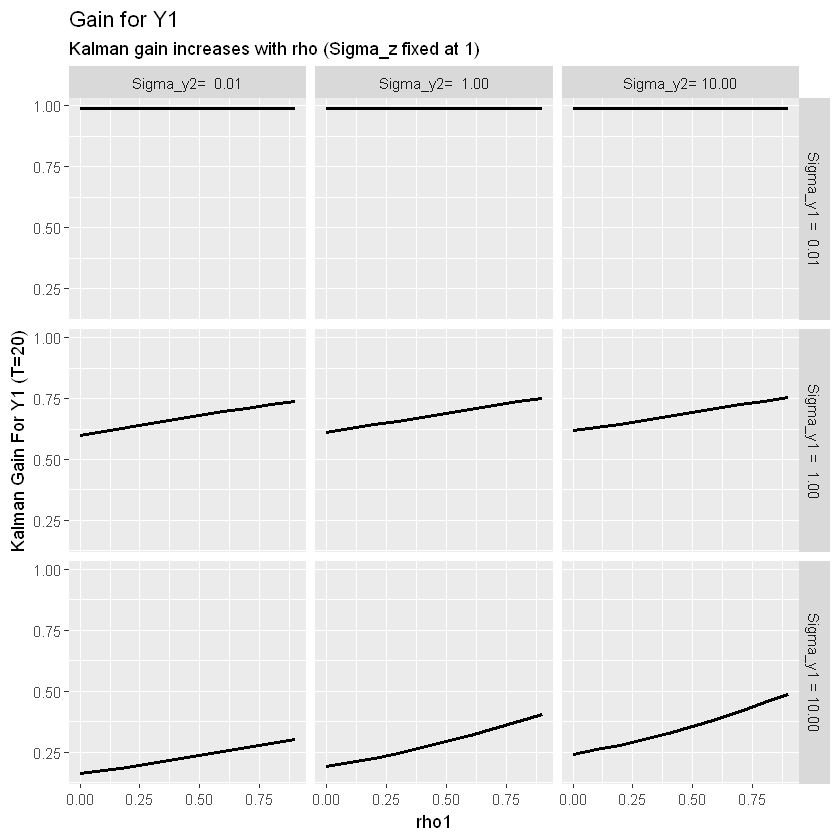

In [18]:
ggplot(data=df_test, aes(x=r, y=k11))+geom_line(size=1.1)+
  facet_grid(paste0("Sigma_y1 = ",format(sm,scientific=F))~paste0("Sigma_y2= ",format(sp, scientific=F)))+
  labs(x="rho1", y="Kalman Gain For Y1 (T=20)",
       title="Gain for Y1",
       subtitle="Kalman gain increases with rho (Sigma_z fixed at 1)")

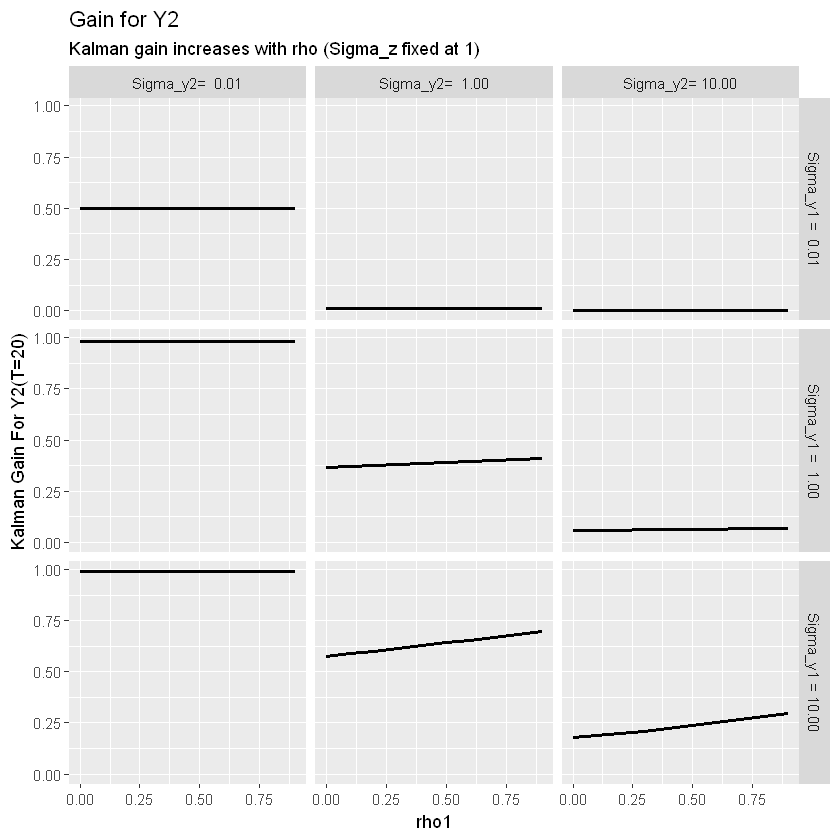

In [19]:
ggplot(data=df_test, aes(x=r, y=k22))+geom_line(size=1.1)+
  facet_grid(paste0("Sigma_y1 = ",format(sm,scientific=F))~paste0("Sigma_y2= ",format(sp, scientific=F)))+
  labs(x="rho1", y="Kalman Gain For Y2(T=20)",
       title="Gain for Y2",
       subtitle="Kalman gain increases with rho (Sigma_z fixed at 1)")

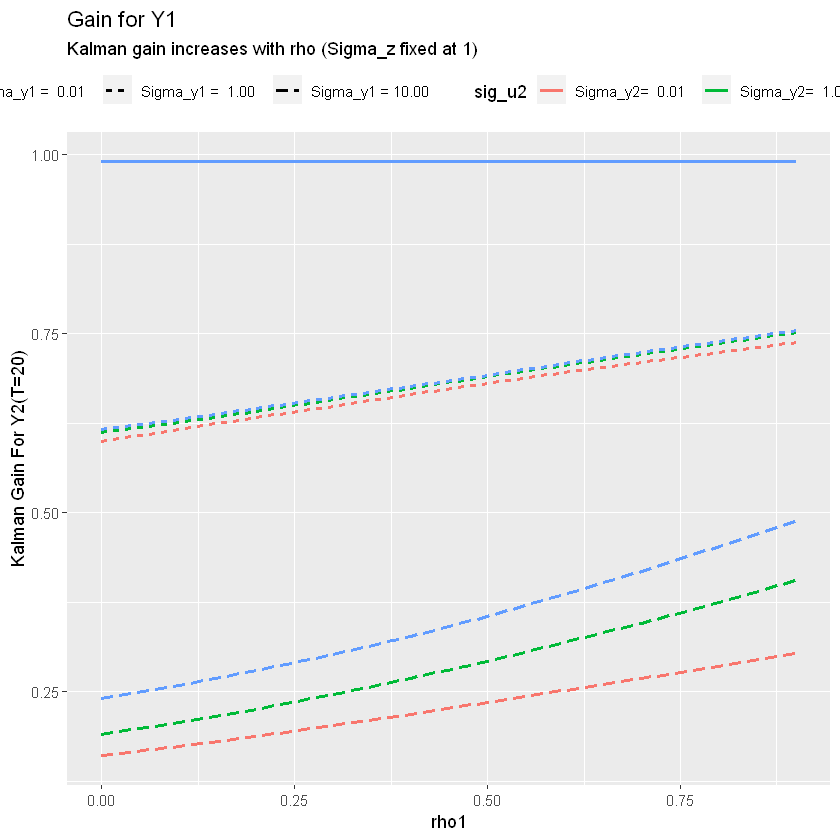

In [20]:
ggplot(data=df_test, aes(x=r, y=k11, color=paste0("Sigma_y2= ",format(sp, scientific=F)), linetype=paste0("Sigma_y1 = ",format(sm,scientific=F))))+geom_path(size=1.1)+
  theme(legend.position="top")+
  scale_linetype(name="sig_u1")+
  scale_color_discrete(name="sig_u2")+
    labs(x="rho1", y="Kalman Gain For Y2(T=20)",
       title="Gain for Y1",
       subtitle="Kalman gain increases with rho (Sigma_z fixed at 1)")